In [44]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model
import seaborn as sns
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

In [2]:
df = pd.read_csv("data/prices-split-adjusted.csv", index_col=0)
df.index = pd.to_datetime(df.index)

In [3]:
df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [4]:
google_stock = df[df['symbol'] == 'GOOG']

In [5]:
google_stock.head()

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,GOOG,312.304948,312.205308,310.955001,313.580158,3927000.0
2010-01-05,GOOG,312.419511,310.830459,309.610028,312.748278,6031900.0
2010-01-06,GOOG,311.761979,302.994813,302.048370,311.761979,7987100.0
2010-01-07,GOOG,303.562685,295.941242,295.218951,303.861575,12876600.0
2010-01-08,GOOG,294.895159,299.886470,293.455551,300.499172,9483900.0


In [6]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
goog_df = google_stock.copy()
goog_df.drop(['symbol'], axis=1, inplace=True)
x = goog_df[['open', 'low', 'high', 'volume']].copy()
y = goog_df['close'].copy()

x[['open', 'low', 'high', 'volume']] = x_scaler.fit_transform(x)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

In [74]:
def load_data(X, seq_len, train_size=0.9):
    amount_of_features = X.shape[1]
    X_mat = X.as_matrix()
    sequence_length = seq_len + 1
    data = []
    
    for index in range(len(X_mat) - sequence_length):
        data.append(X_mat[index: index + sequence_length])
    
    data = np.array(data)
    train_split = int(round(train_size * data.shape[0]))
    train_data = data[:train_split, :]
    
    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]
    
    x_test = data[train_split:, :-1] 
    y_test = data[train_split:, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return x_train, y_train, x_test, y_test

In [75]:
window = 22
x['close'] = y
X_train, y_train, X_test, y_test = load_data(x, window)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print (X_train[0], y_train[0])

(1565, 22, 5) (1565,) (174, 22, 5) (174,)
[[ 0.15704696  0.16116746  0.15638998  0.1317225   0.15939908]
 [ 0.15723843  0.15888449  0.15499506  0.20246902  0.15709185]
 [ 0.15613951  0.14604929  0.15334121  0.26818406  0.14394234]
 [ 0.14243617  0.13445699  0.14009362  0.43252209  0.13210528]
 [ 0.12795029  0.13146379  0.13445546  0.3184921   0.13872603]
 [ 0.13832355  0.1356323   0.13546617  0.48640628  0.1379653 ]
 [ 0.13265404  0.13052526  0.13020388  0.3271972   0.12907917]
 [ 0.11503787  0.1186032   0.12203482  0.43807453  0.12624527]
 [ 0.12120685  0.12613696  0.12689613  0.2858228   0.12855249]
 [ 0.12906589  0.12210374  0.12636158  0.36641044  0.12031836]
 [ 0.11895908  0.12062405  0.12373877  0.29099208  0.12668832]
 [ 0.12293853  0.11977851  0.12003013  0.21906583  0.12066114]
 [ 0.12082392  0.1172081   0.12073176  0.42532947  0.1228095 ]
 [ 0.10505596  0.0855935   0.10718348  0.45857351  0.09524822]
 [ 0.09014547  0.08614311  0.08987641  0.29795279  0.08688037]
 [ 0.08296912

In [9]:
def build_model(input_shape):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    return model

In [36]:
model = build_model(input_shape=(window, 5))

In [37]:
model.fit(X_train, y_train, batch_size=32, epochs=500,
          verbose=0)

In [45]:
save_model(model, "model.h5")

In [46]:
model = load_model("model.h5")

In [38]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [39]:
trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

In [40]:
trainScore = metrics.mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = metrics.mean_squared_error(testY[0], testPredict[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 7.23 RMSE
Test Score: 11.27 RMSE


In [41]:
google_stock_prices = google_stock.close.values.astype('float32')
google_stock_prices = google_stock_prices.reshape(len(google_stock_prices), 1)

In [42]:
trainPredictPlot = np.empty_like(google_stock_prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window:len(trainPredict)+window, :] = trainPredict

testPredictPlot = np.empty_like(google_stock_prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(google_stock_prices) - testPredict.shape[0]):len(google_stock_prices), :] = testPredict

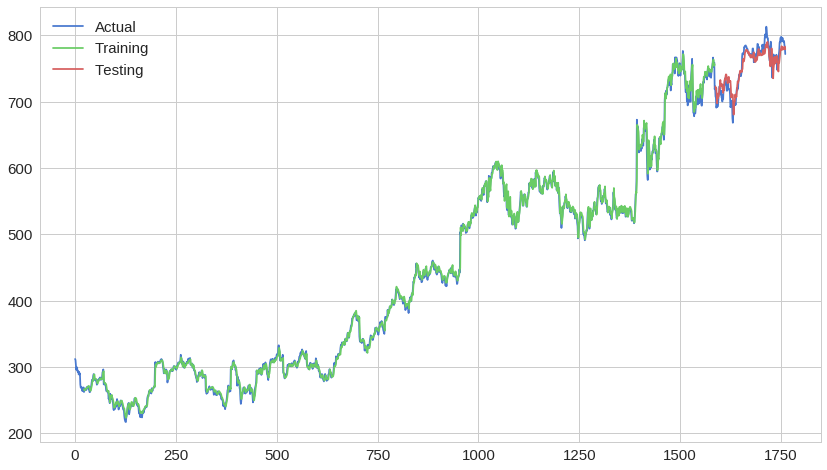

In [43]:
plt.plot(google_stock_prices, label='Actual')
plt.plot(trainPredictPlot, label='Training')
plt.plot(testPredictPlot, label='Testing')
plt.legend(loc='best')
plt.show()